# Getting Data from an API and Cleaning the Data

## APIs
API is an acronym for Application Programming Interface that software uses to access data, server software, or other applications.  In simple terms, it is a software intermediary that allows two applications to "talk" to each other.  They are quite versatile and can be used on web-based systems, operating systems, database systems and computer hardware.

A simplified example would be when you sign into Twitter from your phone you are telling the Twitter application that you would like to access your account. The mobile application makes a call to an API to retrieve your TWitter account and credentials. Twitter would then access this information from one of its servers and return the data to the mobile application.  This is an example of a web API, and will be what we use in this activity.

APIs depend on the owner of the dataset. The data can be either offered for free or be available at a cost. The owner can also limit the number of requests that a single user can make or the amount of data they can access.

## Data Wrangling
Broadly, data wrangling (also called data munging) can be split into 3 tasks (in no particular order and often repeated):
- data cleaning (e.g., renaming columns, reordering, handling duplicates or missing data, filtering to desired subsets)
- data transformation (changing the data's structure to facilitate downstream analysis, such as transposing the data, ensuring there is only one observation per row)
- data enrichments (e.g., merge new data with the origina data by appending new rows/columns or use the original data to create new data).
This activity just scratches the surface of this topic.


## Learning Goals
- Begin to understand the frequently employed steps in data wrangling
- Explore an API to find and collect temperature data
- Use binary search to find the city we want
- Clean the data
- Visualize the results

For this activity, we will collect daily temperature data from the National Centers for Environmental Information (NCEI) API.  The site is here: https://www.ncdc.noaa.gov/cdo-web/webservices/v2 and is part of the National Oceanic and Atmospheric Adminsitration (NOAA).  NOAA's mission is to understand and predict changes in climate, weather, ocean, and coasts,to share that knowledge and information with others, and to conserve and manage coastal and marine ecosystems and resources.


### Token Request
To gain access to the NCDC Web Services, you have to register with your email address and will be sent a unique token.  Registration is here: https://www.ncdc.noaa.gov/cdo-web/token.  Get your token now and be prepared to paste it where indicated in the make_request() function below.

Online documentation about how to access specific data can be found here: https://www.ncdc.noaa.gov/cdo-web/webservices/v2.  The API limits users to 5 requests per second and 10,000 requests per day.  (If requests exceed this amount, you will get a clinet error with a status code in the 400s.  More about status codes can be found here: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status.)


We will use a convenience function for making requests with a specific endpoint and providing our token.  The requests library manages turning our dictionary of search parameters to a query string.  This function was written by Stefanie Molin, the author of Hands on Data Analysis with Pandas (see references).  To use it, you will need to first replace "PASTE_YOUR_TOKEN_HERE" with your personal token.



In [1]:
import requests

def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        A response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'PASTE_YOUR_TOKEN_HERE' # paste token here
        },
        params=payload
    )

### Determine the data category

In [8]:
# call our make_request function to see which data sets are available, and we pass a dictionary to get datasets that have
# data after the specific start date
respone = make_request('datasets', {'startdate': '2018-10-01'})
response.status_code # 200 means successful-- see link with status codes

200

We now use the json() method on our response object to get the payload.  A payload in API is the actual data pack that is sent with the GET method in HTTP.  It is the crucial information that you submit to the server when you are making an API request. The payload can be sent or received in various formats, including JSON.
The two primary parts that make up JSON are keys and values. Together they make a key/value pair, like a dictionary.

In [5]:
payload = response.json()
payload.keys()

dict_keys(['metadata', 'results'])

Here, metadata gives us information about the results.  The results key has the data we requested.  It is a list of what will be rows in our dataframe.  Each entry in the list is a dictionary.

In [6]:
# look at dictionary keys to get fields
payload['results'][0].keys()

dict_keys(['uid', 'mindate', 'maxdate', 'name', 'datacoverage', 'id'])

In [7]:
# extract just id and name fields using list comprehension
[(data['id'], data['name']) for data in payload['results']]

[('GHCND', 'Daily Summaries'),
 ('GSOM', 'Global Summary of the Month'),
 ('GSOY', 'Global Summary of the Year'),
 ('NEXRAD2', 'Weather Radar (Level II)'),
 ('NEXRAD3', 'Weather Radar (Level III)'),
 ('NORMAL_ANN', 'Normals Annual/Seasonal'),
 ('NORMAL_DLY', 'Normals Daily'),
 ('NORMAL_HLY', 'Normals Hourly'),
 ('NORMAL_MLY', 'Normals Monthly'),
 ('PRECIP_15', 'Precipitation 15 Minute'),
 ('PRECIP_HLY', 'Precipitation Hourly')]

We want daily summaries, so we will ask for the GHCND data.  We will pass this as the dataset id as the payload in the make_request() function so the API knows which dataset we are asking about.

In [9]:
# get data category id
response = make_request(
    'datacategories', payload={'datasetid': 'GHCND'}
)
response.status_code # 200 indicates success

200

In [10]:
# response returns metadata and results, so look at results
response.json()['results']

[{'name': 'Evaporation', 'id': 'EVAP'},
 {'name': 'Land', 'id': 'LAND'},
 {'name': 'Precipitation', 'id': 'PRCP'},
 {'name': 'Sky cover & clouds', 'id': 'SKY'},
 {'name': 'Sunshine', 'id': 'SUN'},
 {'name': 'Air Temperature', 'id': 'TEMP'},
 {'name': 'Water', 'id': 'WATER'},
 {'name': 'Wind', 'id': 'WIND'},
 {'name': 'Weather Type', 'id': 'WXTYPE'}]

For this activity, we are interested in temperature, so we will use the id TEMP.  We also limit the number of datatypes to return to 100 (if we want more, we can make another request later).

In [11]:
# get data type id
response = make_request(
    'datatypes',
    payload={
        'datacategoryid': 'TEMP', 
        'limit': 100
    }
)
response.status_code

200

We want to take the id and name fields for each of the entries in the results portion of the data.  We are interested in temperature, which we can find at the bottom of the results.


In [13]:
[(datatype['id'], datatype['name']) for datatype in response.json()['results']] # look at the last 5

[('CDSD', 'Cooling Degree Days Season to Date'),
 ('DATN',
  'Number of days included in the multiday minimum temperature (MDTN)'),
 ('DATX',
  'Number of days included in the multiday maximum temperature (MDTX)'),
 ('DLY-DUTR-NORMAL', 'Long-term averages of daily diurnal temperature range'),
 ('DLY-DUTR-STDDEV',
  'Long-term standard deviations of daily diurnal temperature range'),
 ('DLY-TAVG-NORMAL', 'Long-term averages of daily average temperature'),
 ('DLY-TAVG-STDDEV',
  'Long-term standard deviations of daily average temperature'),
 ('DLY-TMAX-NORMAL', 'Long-term averages of daily maximum temperature'),
 ('DLY-TMAX-STDDEV',
  'Long-term standard deviations of daily maximum temperature'),
 ('DLY-TMIN-NORMAL', 'Long-term averages of daily minimum temperature'),
 ('DLY-TMIN-STDDEV',
  'Long-term standard deviations of daily minimum temperature'),
 ('EMNT', 'Extreme minimum temperature for the period.'),
 ('EMXT', 'Extreme maximum temperature for the period.'),
 ('HDSD', 'Heating De

### Determine the Location

In [14]:
# get location category id 
response = make_request(
    'locationcategories', 
    payload={'datasetid': 'GHCND'}
)
response.status_code

200

The function pprint() lets us print dictionaries in an easier to read format.  

In [15]:
import pprint
pprint.pprint(response.json())

{'metadata': {'resultset': {'count': 12, 'limit': 25, 'offset': 1}},
 'results': [{'id': 'CITY', 'name': 'City'},
             {'id': 'CLIM_DIV', 'name': 'Climate Division'},
             {'id': 'CLIM_REG', 'name': 'Climate Region'},
             {'id': 'CNTRY', 'name': 'Country'},
             {'id': 'CNTY', 'name': 'County'},
             {'id': 'HYD_ACC', 'name': 'Hydrologic Accounting Unit'},
             {'id': 'HYD_CAT', 'name': 'Hydrologic Cataloging Unit'},
             {'id': 'HYD_REG', 'name': 'Hydrologic Region'},
             {'id': 'HYD_SUB', 'name': 'Hydrologic Subregion'},
             {'id': 'ST', 'name': 'State'},
             {'id': 'US_TERR', 'name': 'US Territory'},
             {'id': 'ZIP', 'name': 'Zip Code'}]}


### Binary Search

For this activity, we are interested in "CITY".  We will need to find the location ID for the city we want.  However, there are almost 2000 cities to choose from, so we don't want to look through the list to find the id by visual inspection.  We will choose to focus on San Francisco, one of the largest cities in Northern California.

This function (written by Stefanie Molin, the author of Hands on Data Analysis with Pandas) conducts a binary search.  Binary search is an efficient algorithm for finding an item from a sorted list of items. It works by repeatedly dividing in half the portion of the list that could contain the item, until you've narrowed down the possible locations to just one.  

We can ask the API to return the cities sorted.  The function get_item() makes the first request to see how big the list is and then it looks at its first value.  Then it compares the item we are searching for (alphabetically) to the current name, and depending on the result, then continues the search in half the data.  This process repeats recursively until the result is found or until there is no more splitting of data that is possible.  Recursion means we call the function from inside itself and carefully define a base condition so that the search will eventually stop.

Because APIs often restrict the number of requests that can be made, using an efficient search algorithm (e.g., binary) is helpful in limiting the requests needed to find what we want.

In [21]:
def get_item(name, what, endpoint, start=1, end=None):
    """
    Grab the JSON payload for a given field by name using binary search.

    Parameters:
        - name: The item to look for.
        - what: Dictionary specifying what the item in `name` is.
        - endpoint: Where to look for the item.
        - start: The position to start at. We don't need to touch this, but the
                 function will manipulate this with recursion.
        - end: The last position of the items. Used to find the midpoint, but
               like `start` this is not something we need to worry about.

    Returns:
        Dictionary of the information for the item if found otherwise 
        an empty dictionary.
    """
    # find the midpoint which we use to cut the data in half each time
    mid = (start + (end or 1)) // 2
    
    # lowercase the name so this is not case-sensitive
    name = name.lower()
    
    # define the payload we will send with each request
    payload = {
        'datasetid': 'GHCND',
        'sortfield': 'name',
        'offset': mid, # we will change the offset each time
        'limit': 1 # we only want one value back
    }
    
    # make our request adding any additional filter parameters from `what`
    response = make_request(endpoint, {**payload, **what})
    
    if response.ok:
        payload = response.json()

        # if response is ok, grab the end index from the response metadata the first time through
        end = end or payload['metadata']['resultset']['count']
        
        # grab the lowercase version of the current name
        current_name = payload['results'][0]['name'].lower()
        
        # if what we are searching for is in the current name, we have found our item
        if name in current_name:
            return payload['results'][0] # return the found item
        else:
            if start >= end: 
                # if our start index is greater than or equal to our end, we couldn't find it
                return {}
            elif name < current_name:
                # our name comes before the current name in the alphabet, so we search further to the left
                return get_item(name, what, endpoint, start, mid - 1)
            elif name > current_name:
                # our name comes after the current name in the alphabet, so we search further to the right
                return get_item(name, what, endpoint, mid + 1, end)    
    else:
        # response wasn't ok, use code to determine why
        print(f'Response not OK, status: {response.status_code}')

In [22]:
# get San Francisco id 
sf = get_item('San Francisco', {'locationcategoryid': 'CITY'}, 'locations')
sf

{'mindate': '1893-01-01',
 'maxdate': '2023-04-04',
 'name': 'San Francisco, CA US',
 'datacoverage': 1,
 'id': 'CITY:US060031'}

We now have the city ID for San Francisco: US060031. 

Let's request San Francisco's temperature data (in Celsius) for October 2018.  We will need to use all of the parameters we have obtained previously by exploring the API.  For example
- datasetid is GHCND
- location id is CITY:US060031 (or we can access this with sf['id']
- startdate is 2018-10-01
- enddate is 2018-10-31
- datatypeid is ['TAVG', 'TMAX', 'TMIN'] (average, maximum and minimum temperatures)
- units is metric (if we want Celsius)
- limit is 1000 (or another number you choose)

In [23]:
# get SF daily summaries data 
response = make_request(
    'data', 
    {
        'datasetid': 'GHCND',
        'locationid': sf['id'],
        'startdate': '2018-10-01',
        'enddate': '2018-10-31',
        'datatypeid': ['TAVG', 'TMAX', 'TMIN'], # average, max, and min temperature
        'units': 'metric',
        'limit': 1000
    }
)
response.status_code

200

### Create a Pandas DataFrame

In [25]:
import pandas as pd

df = pd.DataFrame(response.json()['results'])
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TMAX,GHCND:USC00040693,",,7,0800",23.9
1,2018-10-01T00:00:00,TMIN,GHCND:USC00040693,",,7,0800",12.2
2,2018-10-01T00:00:00,TMAX,GHCND:USC00041967,",,7,1600",26.1
3,2018-10-01T00:00:00,TMIN,GHCND:USC00041967,",,7,1600",16.1
4,2018-10-01T00:00:00,TMAX,GHCND:USC00043244,",,7,1600",26.1


In [26]:
# see the unique types of data in the data frame
df.datatype.unique()

array(['TMAX', 'TMIN', 'TAVG'], dtype=object)

In [27]:
df.datatype.value_counts()

TMAX    410
TMIN    409
TAVG    181
Name: datatype, dtype: int64

We can see that we have a ton of observations.  If we had only one observation per day, we would expect 31 of each type.  This indicates we have a data frame with multiple stations reporting, and we might be interested in limiting this to just one station.  Let's limit our results to just the San Francisco Downtown station located near Market Street (on the corner of Hermann and Buchanan Streets).

In [28]:
downtownsf = get_item('San Francisco Downtown', {'locationid': sf['id']}, 'stations')
downtownsf

{'elevation': 45.7,
 'mindate': '1921-01-01',
 'maxdate': '2023-04-02',
 'latitude': 37.7705,
 'name': 'SAN FRANCISCO DOWNTOWN, CA US',
 'datacoverage': 0.9999,
 'id': 'GHCND:USW00023272',
 'elevationUnit': 'METERS',
 'longitude': -122.4269}

We can now update our request with the station id for downtown San Francisco.

In [40]:
# get SF daily summaries data 
response = make_request(
    'data', 
    {
        'datasetid': 'GHCND',
        'stationid': downtownsf['id'],
        'locationid': sf['id'],
        'startdate': '2018-10-01',
        'enddate': '2018-10-31',
        'datatypeid': ['TAVG', 'TMAX', 'TMIN'], # average, max, and min temperature
        'units': 'metric',
        'limit': 1000
    }
)
response.status_code

200

In [41]:
import pandas as pd

df = pd.DataFrame(response.json()['results'])
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TMAX,GHCND:USW00023272,",,W,2400",22.2
1,2018-10-01T00:00:00,TMIN,GHCND:USW00023272,",,W,2400",15.0
2,2018-10-02T00:00:00,TMAX,GHCND:USW00023272,",,W,2400",25.6
3,2018-10-02T00:00:00,TMIN,GHCND:USW00023272,",,W,2400",16.1
4,2018-10-03T00:00:00,TMAX,GHCND:USW00023272,",,W,2400",21.7


In [42]:
# see the unique types of data in the data frame
df.datatype.unique()

array(['TMAX', 'TMIN'], dtype=object)

In [43]:
df.datatype.value_counts()

TMAX    31
TMIN    31
Name: datatype, dtype: int64

This data set has 31 entries, one per day, for each maximum and minumum temperature, respectively.

Apparently, the downtown San Francisco station doesn't have average temperature but does have a maximum and a minimum temperature for each day.  

We will save this data as a CSV file in case we want it for other applications.  The code below will create and save a CSV file to your working directory.

In [45]:
# write the data to a CSV file
df.to_csv('SF_temperatures.csv', index=False)

### Renaming Columns

The value column contains temperatures in degrees Celsius.  We should rename this column so it is clear at first glance what is contained in this column.  We can rename columns with the rename() method, which takes a dictionary mapping the old column name to the new column name.  By passing inplace = True, this change will update the original dataframe instead of creating a new dataframe.  We can also transform all column names to uppercase wtih the rename() method.

In [46]:
df.rename(
    columns={
        'value': 'temp_C'
    }, inplace=True
)

In [47]:
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'temp_C'], dtype='object')

In [ ]:
# upper case
df.rename(str.upper, axis='columns').columns

### Type Conversion
Python has a datetime module which supplies classes for manipulating dates and times (e.g., arithmetic of dates and times, efficient attribute extraction for output formatting and manipulation, converting to common time zones). 
The date column is not currently being stored as a datetime object, but we can convert it.

In [48]:
df.dtypes

date           object
datatype       object
station        object
attributes     object
temp_C        float64
dtype: object

In [49]:
df.loc[:,'date'] = pd.to_datetime(df.date)
df.dtypes

date          datetime64[ns]
datatype              object
station               object
attributes            object
temp_C               float64
dtype: object

In [50]:
df.date.describe(datetime_is_numeric=True)

count                     62
mean     2018-10-16 00:00:00
min      2018-10-01 00:00:00
25%      2018-10-08 06:00:00
50%      2018-10-16 00:00:00
75%      2018-10-23 18:00:00
max      2018-10-31 00:00:00
Name: date, dtype: object

It might make sense to set the datetime as the index (currently, the index starts at 0 and doesn't have a specific meaning in terms of an observation).  Here we read the CSV file we saved, ensure all times are in Pacific Standard Time, and set the date column to be the index for the dataframe.

In [55]:
sf_PST = pd.read_csv(
    'SF_temperatures.csv', index_col='date', parse_dates=True
).tz_localize('US/Pacific')
sf_PST.rename(
    columns={
        'value': 'temp_C'
    }, inplace=True
)
sf_PST.head()

,datatype,station,attributes,temp_C
date,,,,
2018-10-01 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2
2018-10-01 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",15.0
2018-10-02 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6
2018-10-02 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",16.1
2018-10-03 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",21.7


### Add a column
We are very accustomed to thinking in degrees Fahrenheit in the United States, so we might wish to add a new column with this.  The linear equation which relates this two scales is $F = 9.5C + 32$.

In [57]:
sf_PST.assign(temp_F=(sf_PST.temp_C * 9/5) + 32)

,datatype,station,attributes,temp_C,temp_F
date,,,,,
2018-10-01 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,71.96
2018-10-01 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",15.0,59.00
2018-10-02 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6,78.08
2018-10-02 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",16.1,60.98
2018-10-03 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",21.7,71.06
...,...,...,...,...,...
2018-10-29 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",13.3,55.94
2018-10-30 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",20.0,68.00
2018-10-30 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.2,53.96


We can also use astype() to perform conversions.  For example, we might be satisfied with an integer for temperatures instead of having decimals representing hundredths.  Lambda functions are often used with assign().  Notice that we have to redefine the Fahrenheit conversion because when we did it above, the result is a *new* dataframe, not the original.

In [61]:
sf_PST = sf_PST.assign(
    temp_C_whole=lambda x: x.temp_C.astype('int'),
    temp_F=lambda x: (x.temp_C * 9/5) + 32,
    temp_F_whole=lambda x: x.temp_F.astype('int')
)
sf_PST.head()

,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-01 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,22,71.96,71
2018-10-01 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",15.0,15,59.00,59
2018-10-02 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6,25,78.08,78
2018-10-02 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",16.1,16,60.98,60
2018-10-03 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",21.7,21,71.06,71


### Reordering, reindexing and sorting

If we want to find the days that reached the hottest temperature in the month of October 2018 in downtown San Francisco, we can sort the values by temp_C in descending order.

In [62]:
sf_PST[sf_PST.datatype == 'TMAX'].sort_values(by='temp_C', ascending=False).head(10)

,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-15 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",27.2,27,80.96,80
2018-10-07 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",26.1,26,78.98,78
2018-10-08 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",26.1,26,78.98,78
2018-10-12 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6,25,78.08,78
2018-10-02 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6,25,78.08,78
2018-10-31 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",23.9,23,75.02,75
2018-10-26 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,22,71.96,71
2018-10-25 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,22,71.96,71
2018-10-19 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,22,71.96,71


Notice that there are some ties.  For example, 26.1 Celsius appears twice, as does 25.6.  In the first tie, the earlier date comes first (October 7th before October 8th), but in the second tie, the opposite is true (October 12 is listed before October 2).  We can use other columns to break ties and consistenty list tied values by the earliest date first.

In [63]:
# sort by descending temperature for TMAX, and for breaking ties, sort by ascending date
sf_PST[sf_PST.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True]).head(10)

,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-15 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",27.2,27,80.96,80
2018-10-07 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",26.1,26,78.98,78
2018-10-08 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",26.1,26,78.98,78
2018-10-02 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6,25,78.08,78
2018-10-12 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6,25,78.08,78
2018-10-31 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",23.9,23,75.02,75
2018-10-01 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,22,71.96,71
2018-10-19 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,22,71.96,71
2018-10-25 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,22,71.96,71


We can also sort to see the lowest temperatures for the month of October 2018.

In [66]:
sf_PST[sf_PST.datatype == 'TMIN'].nsmallest(n=10, columns='temp_C')

,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-19 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",11.1,11,51.98,51
2018-10-20 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",11.1,11,51.98,51
2018-10-21 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",11.1,11,51.98,51
2018-10-17 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",11.7,11,53.06,53
2018-10-18 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",11.7,11,53.06,53
2018-10-10 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.2,12,53.96,53
2018-10-11 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.2,12,53.96,53
2018-10-12 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.2,12,53.96,53
2018-10-16 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.2,12,53.96,53


We might be interested in looking at a particular period in October 2018, for example, October 10th through October 15th (inclusive).

In [67]:
sf_PST['2018-10-10':'2018-10-15']

,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-10 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",17.8,17,64.04,64
2018-10-10 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.2,12,53.96,53
2018-10-11 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",18.9,18,66.02,66
2018-10-11 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.2,12,53.96,53
2018-10-12 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6,25,78.08,78
2018-10-12 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.2,12,53.96,53
2018-10-13 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",17.8,17,64.04,64
2018-10-13 00:00:00-07:00,TMIN,GHCND:USW00023272,",,W,2400",12.8,12,55.04,55
2018-10-14 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",17.8,17,64.04,64


### Plot the maximum daily temperature
Let's plot the daily maximum temperature for downtown San Francisco in October 2018 in degrees Fahrenheit.  We will subset the dataframe to only include the TMAX datatypes.

In [70]:
sf_max = sf_PST[sf_PST.datatype == 'TMAX']
sf_max.head()

,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-01 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",22.2,22,71.96,71
2018-10-02 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",25.6,25,78.08,78
2018-10-03 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",21.7,21,71.06,71
2018-10-04 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",20.0,20,68.00,68
2018-10-05 00:00:00-07:00,TMAX,GHCND:USW00023272,",,W,2400",18.9,18,66.02,66


In [76]:
import matplotlib.pyplot as plt # we use this module for plotting
from matplotlib.ticker import StrMethodFormatter # for formatting the axis

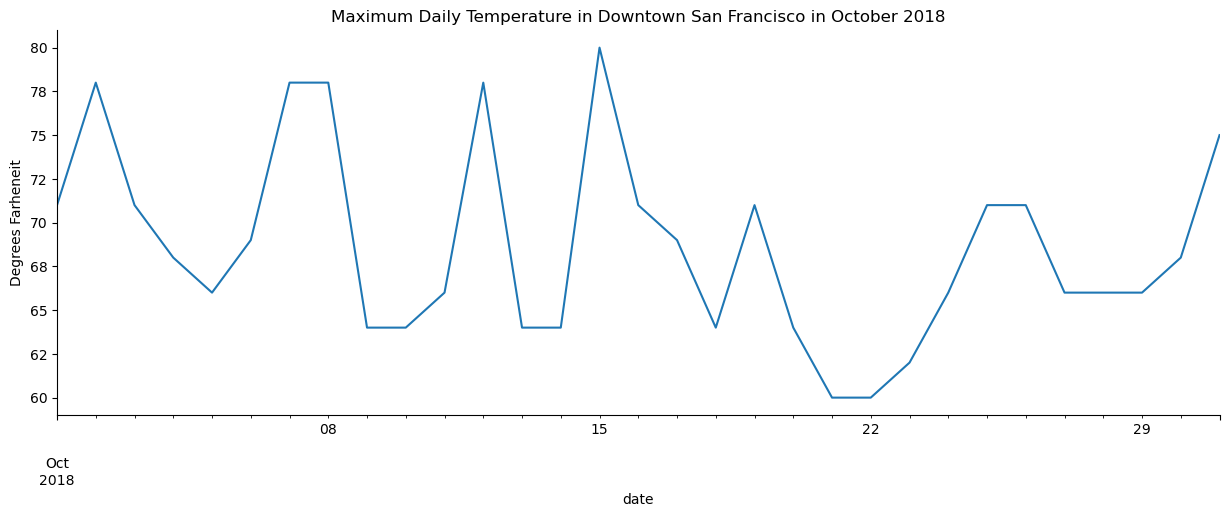

In [78]:
# plot the maximum daily temperatures for October 2018
ax = sf_max.plot(
    y='temp_F_whole', figsize=(15, 5), legend=False,
    title='Maximum Daily Temperature in Downtown San Francisco in October 2018'
)

# formatting

ax.set_ylabel('Degrees Farheneit')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# show the plot
plt.show()

## Task:

- Create a dataframe with temperatures recorded in Los Angeles in January 2023.  How many entries do you have?  Does this exceed the number of days in the month?  Explain why this might be.
- How many unique stations are included in this data set?
- Create a new dataframe with measurements from station USC00040192 only.
- Save this dataset to a CSV file.
- What was the hottest temperature recorded at station USC00040192 in January 2023 in Los Angeles in degrees Fahrenheit?  One what day did this occur?
- Make a plot with dates along the x-axis and Degrees Fahrenheit along the y-axis showing the maximum daily temperature in Los Angeles in January 2023.
- Does the data set contain data for all days in January?
- Explain in a paragraph how binary search works.

## Solution (one possible implementation)

In [114]:
# use binary search to get Los Angeles id

LA = get_item('Los Angeles', {'locationcategoryid': 'CITY'}, 'locations')
LA

{'mindate': '1893-01-01',
 'maxdate': '2023-04-05',
 'name': 'Los Angeles, CA US',
 'datacoverage': 1,
 'id': 'CITY:US060013'}

In [134]:
# get LA daily summaries data 
response = make_request(
    'data', 
    {
        'datasetid': 'GHCND',
        'locationid': LA['id'],
        'startdate': '2023-01-01',
        'enddate': '2023-01-31',
        'datatypeid': ['TAVG', 'TMAX', 'TMIN'], # average, max, and min temperature
        'units': 'metric',
        'limit': 1000
    }
)
response.status_code

200

In [135]:
import pandas as pd

df = pd.DataFrame(response.json()['results'])
df.head(15)

,date,datatype,station,attributes,value
0,2023-01-01T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",17.2
1,2023-01-01T00:00:00,TMIN,GHCND:USC00040192,",,7,1600",10.6
2,2023-01-01T00:00:00,TMAX,GHCND:USC00041194,",,7,0700",15.0
3,2023-01-01T00:00:00,TMIN,GHCND:USC00041194,",,7,0700",6.7
4,2023-01-01T00:00:00,TMAX,GHCND:USC00042214,",,7,1600",16.1
5,2023-01-01T00:00:00,TMIN,GHCND:USC00042214,",,7,1600",10.0
6,2023-01-01T00:00:00,TMAX,GHCND:USC00046719,",,7,0800",15.6
7,2023-01-01T00:00:00,TMIN,GHCND:USC00046719,",,7,0800",8.9
8,2023-01-01T00:00:00,TMAX,GHCND:USC00047326,",,7,1600",15.6
9,2023-01-01T00:00:00,TMIN,GHCND:USC00047326,",,7,1600",12.2


In [136]:
df.datatype.unique()

array(['TMAX', 'TMIN', 'TAVG'], dtype=object)

In [137]:
df.datatype.value_counts()

TMAX    411
TMIN    410
TAVG    179
Name: datatype, dtype: int64

In [148]:
# how many different stations in Los Angeles?
df.station.unique()

array(['GHCND:USC00040192', 'GHCND:USC00041194', 'GHCND:USC00042214',
       'GHCND:USC00046719', 'GHCND:USC00047326', 'GHCND:USC00047888',
       'GHCND:USC00049152', 'GHCND:USC00049785', 'GHCND:USR0000CACT',
       'GHCND:USR0000CBEV', 'GHCND:USR0000CCHB', 'GHCND:USR0000CCLE',
       'GHCND:USR0000CCP9', 'GHCND:USR0000CLTU', 'GHCND:USR0000CMAL',
       'GHCND:USR0000CMIL', 'GHCND:USR0000CSFD', 'GHCND:USR0000CWHH',
       'GHCND:USW00003122', 'GHCND:USW00003166', 'GHCND:USW00003167',
       'GHCND:USW00023129', 'GHCND:USW00023130', 'GHCND:USW00023152',
       'GHCND:USW00023174', 'GHCND:USW00093134', 'GHCND:USW00093184',
       'GHCND:USW00093197', 'GHCND:USR0000CCHI'], dtype=object)

Limit the data to just the indicated station from the prompt.

In [168]:
# get LA daily summaries data for specific station 'GHCND:USC00040192'
response = make_request(
    'data', 
    {
        'datasetid': 'GHCND',
        'stationid': 'GHCND:USC00040192',
        'locationid': LA['id'],
        'startdate': '2023-01-01',
        'enddate': '2023-01-31',
        'datatypeid': ['TAVG', 'TMAX', 'TMIN'], # average, max, and min temperature
        'units': 'metric',
        'limit': 1000
    }
)
response.status_code

200

In [186]:
import pandas as pd

df_USC = pd.DataFrame(response.json()['results'])
df_USC.head(15)

,date,datatype,station,attributes,value
0,2023-01-01T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",17.2
1,2023-01-01T00:00:00,TMIN,GHCND:USC00040192,",,7,1600",10.6
2,2023-01-02T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",16.1
3,2023-01-02T00:00:00,TMIN,GHCND:USC00040192,",,7,1600",7.2
4,2023-01-03T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",14.4
5,2023-01-03T00:00:00,TMIN,GHCND:USC00040192,",,7,1600",10.0
6,2023-01-04T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",17.8
7,2023-01-04T00:00:00,TMIN,GHCND:USC00040192,",,7,1600",12.8
8,2023-01-05T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",17.8
9,2023-01-05T00:00:00,TMIN,GHCND:USC00040192,",,7,1600",12.2


In [171]:
df_USC.datatype.value_counts()

TMAX    31
TMIN    31
Name: datatype, dtype: int64

In [187]:
df_USC.rename(
    columns={
        'value': 'temp_C',       
    }, inplace=True
)
df_USC.head()

,date,datatype,station,attributes,temp_C
0,2023-01-01T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",17.2
1,2023-01-01T00:00:00,TMIN,GHCND:USC00040192,",,7,1600",10.6
2,2023-01-02T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",16.1
3,2023-01-02T00:00:00,TMIN,GHCND:USC00040192,",,7,1600",7.2
4,2023-01-03T00:00:00,TMAX,GHCND:USC00040192,",,7,1600",14.4


In [175]:
df_USC.columns

Index(['date', 'datatype', 'station', 'attributes', 'temp_C'], dtype='object')

In [188]:
df_USC.loc[:,'date'] = pd.to_datetime(df_USC.date)


In [189]:
df_USC = df_USC.assign(
    date=lambda x: pd.to_datetime(x.date),
    temp_C_whole=lambda x: x.temp_C.astype('int'),
    temp_F=lambda x: (x.temp_C * 9/5) + 32,
    temp_F_whole=lambda x: x.temp_F.astype('int')
)

df_USC.head()

,date,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2023-01-01,TMAX,GHCND:USC00040192,",,7,1600",17.2,17,62.96,62
1,2023-01-01,TMIN,GHCND:USC00040192,",,7,1600",10.6,10,51.08,51
2,2023-01-02,TMAX,GHCND:USC00040192,",,7,1600",16.1,16,60.98,60
3,2023-01-02,TMIN,GHCND:USC00040192,",,7,1600",7.2,7,44.96,44
4,2023-01-03,TMAX,GHCND:USC00040192,",,7,1600",14.4,14,57.92,57


In [190]:
# write the temp data to a CSV file
df_USC.to_csv('Los Angeles Max and Min Temperatures in Jan 2023.csv', index=False)

In [178]:
# sort by warmest temperatures first and break ties with the date
df_USC[df_USC.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True]).head(10)

,date,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
48,2023-01-25,TMAX,GHCND:USC00040192,",,7,1600",25.6,25,78.08,78
22,2023-01-12,TMAX,GHCND:USC00040192,",,7,1600",23.9,23,75.02,75
50,2023-01-26,TMAX,GHCND:USC00040192,",,7,1600",23.3,23,73.94,73
52,2023-01-27,TMAX,GHCND:USC00040192,",,7,1600",23.3,23,73.94,73
24,2023-01-13,TMAX,GHCND:USC00040192,",,7,1600",22.2,22,71.96,71
46,2023-01-24,TMAX,GHCND:USC00040192,",,7,1600",22.2,22,71.96,71
12,2023-01-07,TMAX,GHCND:USC00040192,",,7,1600",21.7,21,71.06,71
14,2023-01-08,TMAX,GHCND:USC00040192,",,7,1600",21.1,21,69.98,69
54,2023-01-28,TMAX,GHCND:USC00040192,",,7,1600",21.1,21,69.98,69
60,2023-01-31,TMAX,GHCND:USC00040192,",,7,1600",21.1,21,69.98,69


The hottest temperature occured on January 25, 2023 and was 78 degrees Fahrenheit.

In [179]:
# reset index to date
df_USC.set_index('date', inplace=True)
df_USC.head()

,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2023-01-01,TMAX,GHCND:USC00040192,",,7,1600",17.2,17,62.96,62
2023-01-01,TMIN,GHCND:USC00040192,",,7,1600",10.6,10,51.08,51
2023-01-02,TMAX,GHCND:USC00040192,",,7,1600",16.1,16,60.98,60
2023-01-02,TMIN,GHCND:USC00040192,",,7,1600",7.2,7,44.96,44
2023-01-03,TMAX,GHCND:USC00040192,",,7,1600",14.4,14,57.92,57


In [181]:
# get just max temps for plot
la_max = df2[df2.datatype == 'TMAX']
la_max.head()

,datatype,station,attributes,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2023-01-01,TMAX,GHCND:USC00040192,",,7,1600",17.2,17,62.96,62
2023-01-02,TMAX,GHCND:USC00040192,",,7,1600",16.1,16,60.98,60
2023-01-03,TMAX,GHCND:USC00040192,",,7,1600",14.4,14,57.92,57
2023-01-04,TMAX,GHCND:USC00040192,",,7,1600",17.8,17,64.04,64
2023-01-05,TMAX,GHCND:USC00040192,",,7,1600",17.8,17,64.04,64


In [182]:
import matplotlib.pyplot as plt # we use this module for plotting
from matplotlib.ticker import StrMethodFormatter # for formatting the axis

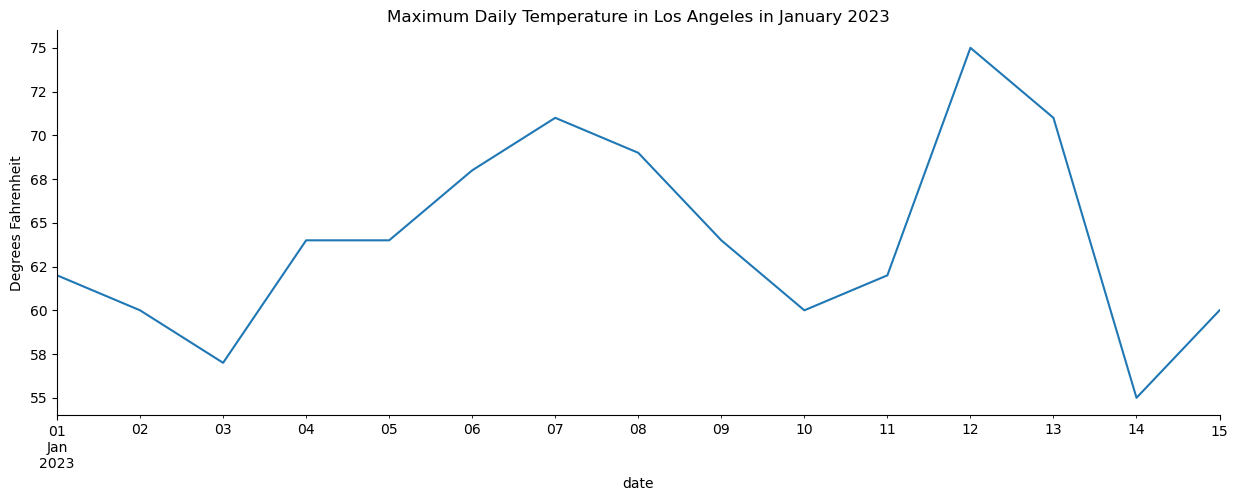

In [183]:
# plot the maximum daily temperatures for January 2023
ax = la_max.plot(
    y='temp_F_whole', figsize=(15, 5), legend=False,
    title='Maximum Daily Temperature in Los Angeles in January 2023'
)

# formatting

ax.set_ylabel('Degrees Fahrenheit')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# show the plot
plt.show()

### References
- Hands on Data Analysis with Pandas by Stefanie Molin (especially Chapter 4)
- National Oceanic and Atmospheric Adminstration (NOAA) National Centers for Environmental Information (NCEI): https://www.ncei.noaa.gov